In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os

import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from nltk.util import ngrams
import string
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
articles_path = '/Users/kuba/Desktop/PBL/EDA/articles/articles_01-01-2024_14h39m35s.csv'
trials_path = '/Users/kuba/Desktop/PBL/EDA/trials/trials_01-01-2024_14h39m35s.csv'

articles = pd.read_csv(articles_path, index_col=0)
trials = pd.read_csv(trials_path, index_col=0)

# Frequency of Word Analysis
Frequency of words analysis in Relevant/not articles (word cloud)

## Articles

In [3]:
# drop rows with missing values in summary column
articles.dropna(subset=['summary'], inplace=True)
articles.dropna(subset=['relevant'], inplace=True)

In [4]:
# for summaries that have doi, keep only eveyrhting in the string after doi
articles['summary'] = articles['summary'].apply(lambda x: x.lower().split('abstract')[1] if 'abstract' in x.lower() else x)

### Stemming

In [5]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to preprocess text
def preprocess_stemming(text):
    stop_words = set(stopwords.words('english'))
    text = text.translate(str.maketrans('', '', string.punctuation))
    stemmer = PorterStemmer()
    words = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in words if word not in stop_words and word.isalpha()]

# Splitting the dataset based on the 'relevant' column
relevant_articles = articles[articles['relevant'] == True]['summary']
non_relevant_articles = articles[articles['relevant'] == False]['summary']

# Word frequency count for relevant articles
word_freq_relevant = Counter()
for summary in relevant_articles.dropna():
    word_freq_relevant.update(preprocess_stemming(summary))

# Word frequency count for non-relevant articles
word_freq_non_relevant = Counter()
for summary in non_relevant_articles.dropna():
    word_freq_non_relevant.update(preprocess_stemming(summary))

# Top words in each class
top_words_relevant = word_freq_relevant.most_common(10)
top_words_non_relevant = word_freq_non_relevant.most_common(10)

top_words_relevant, top_words_non_relevant

[nltk_data] Downloading package punkt to /Users/kuba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kuba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


([('ms', 1522),
  ('cell', 1350),
  ('diseas', 1040),
  ('effect', 937),
  ('multipl', 920),
  ('studi', 870),
  ('sclerosi', 866),
  ('treatment', 828),
  ('patient', 798),
  ('activ', 675)],
 [('patient', 424),
  ('ms', 224),
  ('diseas', 207),
  ('studi', 196),
  ('use', 184),
  ('multipl', 171),
  ('sclerosi', 169),
  ('clinic', 141),
  ('treatment', 139),
  ('cell', 133)])

### Lemmatization

In [6]:
nltk.download('wordnet')

# Function to preprocess text
def preprocess_lemma(text):
    stop_words = set(stopwords.words('english'))
    text = text.translate(str.maketrans('', '', string.punctuation))
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text.lower())
    return [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]

# Splitting the dataset based on the 'relevant' column
relevant_articles = articles[articles['relevant'] == True]['summary']
non_relevant_articles = articles[articles['relevant'] == False]['summary']

# Word frequency count for relevant articles
word_freq_relevant = Counter()
for summary in relevant_articles.dropna():
    word_freq_relevant.update(preprocess_lemma(summary))

# Word frequency count for non-relevant articles
word_freq_non_relevant = Counter()
for summary in non_relevant_articles.dropna():
    word_freq_non_relevant.update(preprocess_lemma(summary))

# Top words in each class
top_words_relevant = word_freq_relevant.most_common(10)
top_words_non_relevant = word_freq_non_relevant.most_common(10)

top_words_relevant, top_words_non_relevant

[nltk_data] Downloading package wordnet to /Users/kuba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


([('m', 1522),
  ('cell', 1350),
  ('disease', 1037),
  ('multiple', 920),
  ('sclerosis', 866),
  ('study', 836),
  ('treatment', 828),
  ('patient', 798),
  ('effect', 743),
  ('mouse', 686)],
 [('patient', 424),
  ('m', 224),
  ('disease', 207),
  ('study', 190),
  ('multiple', 171),
  ('sclerosis', 169),
  ('treatment', 139),
  ('cell', 133),
  ('clinical', 118),
  ('p', 92)])

### Relative Frequencies

In [7]:
def calculate_relative_frequencies(word_counts, total_words):
    return {word: (count / total_words) for word, count in word_counts.items()}

def find_characteristic_keywords(freq_class_1, freq_class_2, threshold=0.01):
    characteristic_keywords = {}
    for word in freq_class_1.keys():
        relative_freq_1 = freq_class_1.get(word, 0)
        relative_freq_2 = freq_class_2.get(word, 0)
        if relative_freq_1 - relative_freq_2 > threshold:
            characteristic_keywords[word] = relative_freq_1
    return characteristic_keywords

# Calculate total words in each class
total_words_relevant = sum(word_freq_relevant.values())
total_words_non_relevant = sum(word_freq_non_relevant.values())

# Calculate relative frequencies
relative_freq_relevant = calculate_relative_frequencies(word_freq_relevant, total_words_relevant)
relative_freq_non_relevant = calculate_relative_frequencies(word_freq_non_relevant, total_words_non_relevant)

In [8]:
# Function to calculate relative frequency difference and get top characteristic words
def get_top_characteristic_words(freq_class_1, freq_class_2, top_n=10):
    diff_freq = {word: freq_class_1.get(word, 0) - freq_class_2.get(word, 0) for word in freq_class_1.keys()}
    # Sort by difference in frequency
    sorted_diff = sorted(diff_freq.items(), key=lambda x: x[1], reverse=True)
    return sorted_diff[:top_n]

# Get the top characteristic words for each class
top_characteristic_words_relevant = get_top_characteristic_words(relative_freq_relevant, relative_freq_non_relevant)
top_characteristic_words_non_relevant = get_top_characteristic_words(relative_freq_non_relevant, relative_freq_relevant)

# Print top characteristic words
print("Top Characteristic Words for Relevant Articles:", top_characteristic_words_relevant)
print("Top Characteristic Words for Non-Relevant Articles:", top_characteristic_words_non_relevant)


Top Characteristic Words for Relevant Articles: [('cell', 0.007679267423948797), ('eae', 0.006139223992510867), ('m', 0.005643383637641729), ('mouse', 0.005391284961500651), ('effect', 0.004641585316014192), ('myelin', 0.003836888179758643), ('demyelination', 0.0033325724004937803), ('oligodendrocyte', 0.003088053840759163), ('cns', 0.0029043814857129214), ('therapeutic', 0.002879553663545026)]
Top Characteristic Words for Non-Relevant Articles: [('patient', 0.009518914541857637), ('pwms', 0.0030387858474134333), ('age', 0.0027479836542973002), ('infection', 0.0026512982865889404), ('vaccination', 0.0024188355936938864), ('case', 0.002092910326046537), ('vaccine', 0.0020428070277161143), ('care', 0.0017152703635907327), ('prevalence', 0.0016977834353242298), ('people', 0.0016663308077437097)]


### TF-IDF

#### All articles, cumulative

In [11]:
def preprocess_lemma(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    if isinstance(text, list):
        words = [word for sublist in text for word in word_tokenize(sublist.lower())]
    else:
        text = text.translate(str.maketrans('', '', string.punctuation))
        words = word_tokenize(text.lower())

    return ' '.join([lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()])

In [12]:
articles.summary = articles.summary.apply(preprocess_lemma)

In [13]:
stp_words = ['doi', 'online', 'ahead', 'multiple', 'sclerosis']

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stp_words, max_features=1000)

# Fit and transform the 'summary' column
X = vectorizer.fit_transform(articles['summary'])

# Get the feature names (words) and their TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = X.toarray()

# Sum the TF-IDF scores for each word across all documents
word_scores = tfidf_scores.mean(axis=0)

# Sort the words by their total score
word_scores_sorted_indices = word_scores.argsort()[::-1]
most_frequent_words = [feature_names[i] for i in word_scores_sorted_indices]

# keep table with top 20 frequent words and their scores (two columns)
most_frequent_words = pd.DataFrame(most_frequent_words, columns=['feature'])

In [14]:
# add column with score
most_frequent_words['score'] = word_scores[word_scores_sorted_indices]

# print top 20 words
print(most_frequent_words.head(10))

      feature     score
0        cell  0.057498
1     patient  0.046966
2     disease  0.045352
3         eae  0.038224
4   treatment  0.035626
5       mouse  0.034243
6       study  0.032941
7      effect  0.032475
8       group  0.027492
9  autoimmune  0.024808


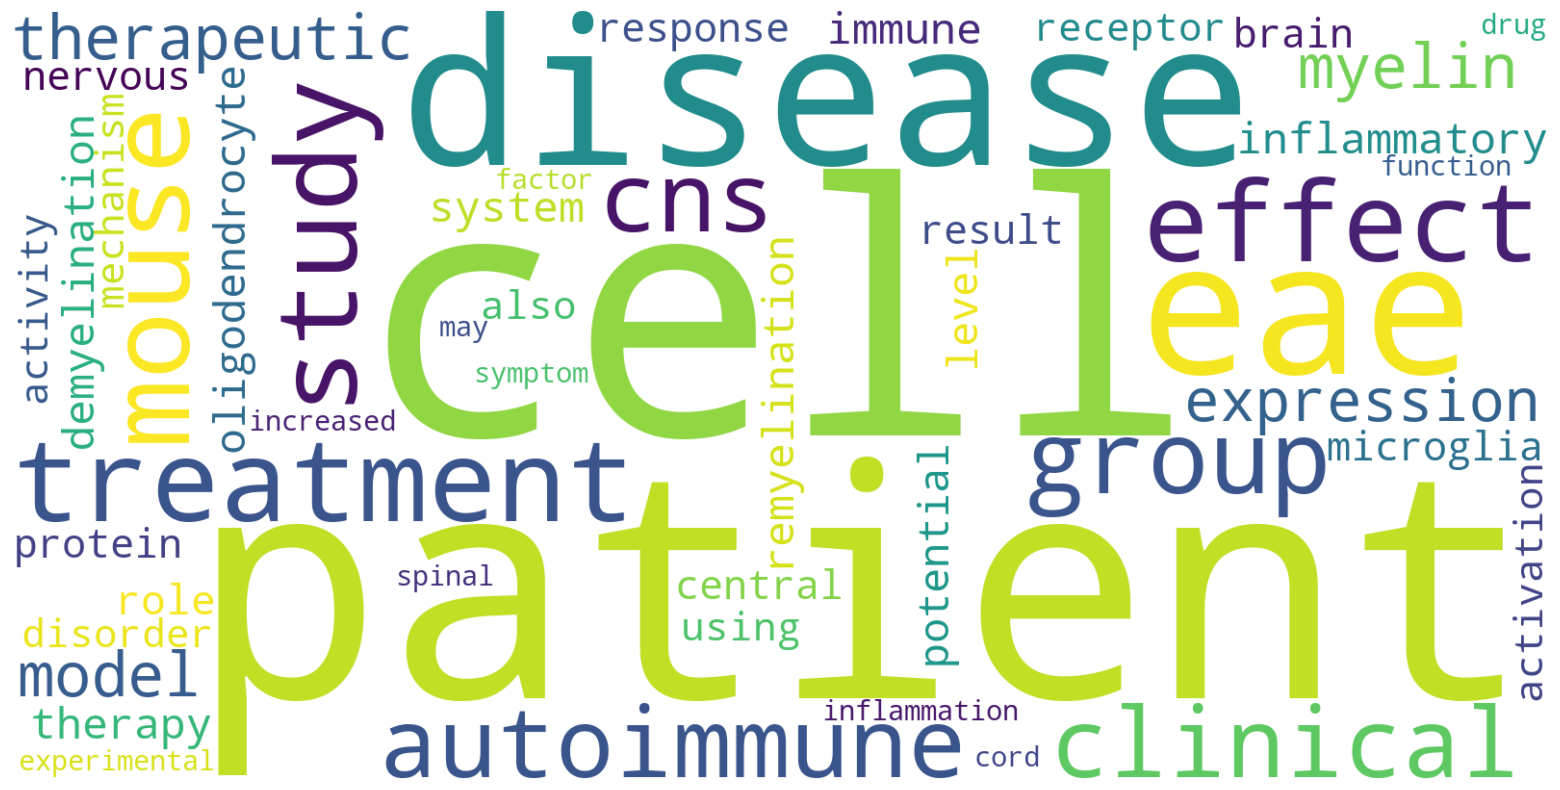

In [327]:
# creating a word cloud for most_frequent_words with size of the word proportional to its score
# create a function to plot word cloud
def create_wordcloud(df, n=20):
    '''df columns: feature, score. Feature is word in the wordloud, the higher the score, the larger the word
    n represents number of words with highest score value to visualize in the wordcloud'''
    df = df.head(n)
    text = dict(zip(df['feature'], df['score']))
    wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=n).generate_from_frequencies(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# create wordcloud for most_frequent_words
create_wordcloud(most_frequent_words, n=50)



#### Relevant/Not Relevant

In [335]:
# Function to get top TF-IDF features for a given matrix and feature names
def get_top_tfidf_features(tfidf_matrix, feature_names, top_n=10):
    # Calculate mean TF-IDF score for each word
    mean_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()

    # Create a dictionary of word-score pairs
    word_scores = dict(zip(feature_names, mean_scores))

    # Sort the words by their scores in descending order
    sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

    # Get the top N features
    top_features = sorted_words[:top_n]

    return top_features

# Function to calculate TF-IDF for a given corpus
def calculate_tfidf(corpus, top_n=10):
    # Initialize the TF-IDF Vectorizer, excluding stop words
    stp_words = ['doi', 'online', 'ahead', 'multiple', 'sclerosis', 'printno']
    tfidf_vectorizer = TfidfVectorizer(stop_words=stp_words)

    # Apply TF-IDF to the corpus
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

    # Extract feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get top TF-IDF features
    top_features = get_top_tfidf_features(tfidf_matrix, feature_names, top_n=top_n)

    return top_features

# Apply preprocessing to each text in the relevant and non-relevant articles
processed_relevant = articles[articles.relevant==True].summary.to_list()
processed_non_relevant = articles[articles.relevant==False].summary.to_list()


# Compute TF-IDF for each class
tfidf_relevant = calculate_tfidf(processed_relevant, top_n=30)
tfidf_non_relevant = calculate_tfidf(processed_non_relevant, top_n=30)


# Create a dataframe with the TF-IDF features,scores and class - 3 columns: feature, score, class
tfidf_df = pd.DataFrame(tfidf_relevant, columns=['feature', 'score'])
tfidf_df['class'] = 'relevant'
tfidf_df = pd.concat([tfidf_df, pd.DataFrame(tfidf_non_relevant, columns=['feature', 'score'])])
tfidf_df['class'] = tfidf_df['class'].fillna('non_relevant')

# print top 20 words per class
tfidf_df.groupby('class').head(20)

# Pivot to show the top 10 words for each class. Rows are numbers from 1 to 10 and columns are classes, subcolumns are "word" and "score"
tfidf_pivot = tfidf_df.pivot_table(index=tfidf_df.index, columns='class', values=['feature', 'score'], aggfunc='first')
tfidf_pivot.columns = [f'{i}_{j}' for i, j in tfidf_pivot.columns]
tfidf_pivot = tfidf_pivot.reset_index()


In [336]:
tfidf_df.reset_index().pivot(index='index', columns='class', values=['feature', 'score'])

feature                         score          
class non_relevant         relevant non_relevant  relevant
index                                                     
0          patient             cell     0.048424  0.041455
1          disease          disease     0.026198  0.031916
2             cell              eae     0.022849  0.030023
3            study          patient     0.020743    0.0271
4        treatment        treatment     0.019585   0.02524
5             pwms            mouse     0.018041  0.025228
6         clinical           effect     0.016384   0.02288
7      vaccination            study     0.016275  0.022577
8            group              cns     0.015731  0.019317
9        infection           myelin     0.015548  0.019024
10        response            group     0.013989  0.018562
11         symptom       autoimmune     0.013493  0.018375
12         therapy      therapeutic     0.013488  0.018335
13             age            model     0.012994  0.017126
14            case    remyelination     0.012567   0.01676
15            data         clinical     0.012076  0.016691
16          effect    demyelination     0.011743  0.016388
17        analysis  oligodendrocyte     0.011611  0.016163
18          people           system     0.011343  0.016125
19           using     inflammatory     0.011165    0.0159
20      associated           immune     0.011051  0.015657
21           level       expression     0.010999  0.015492
22          result          therapy      0.01074  0.015433
23           model        microglia     0.010549  0.014301
24         vaccine        potential     0.010437  0.014253
25            pain             role     0.010263  0.014252
26            care            level     0.010239  0.012962
27           among          nervous     0.010227  0.012946
28      conclusion          central     0.010168  0.012913
29         outcome         receptor     0.010128  0.012464

### WordClouds

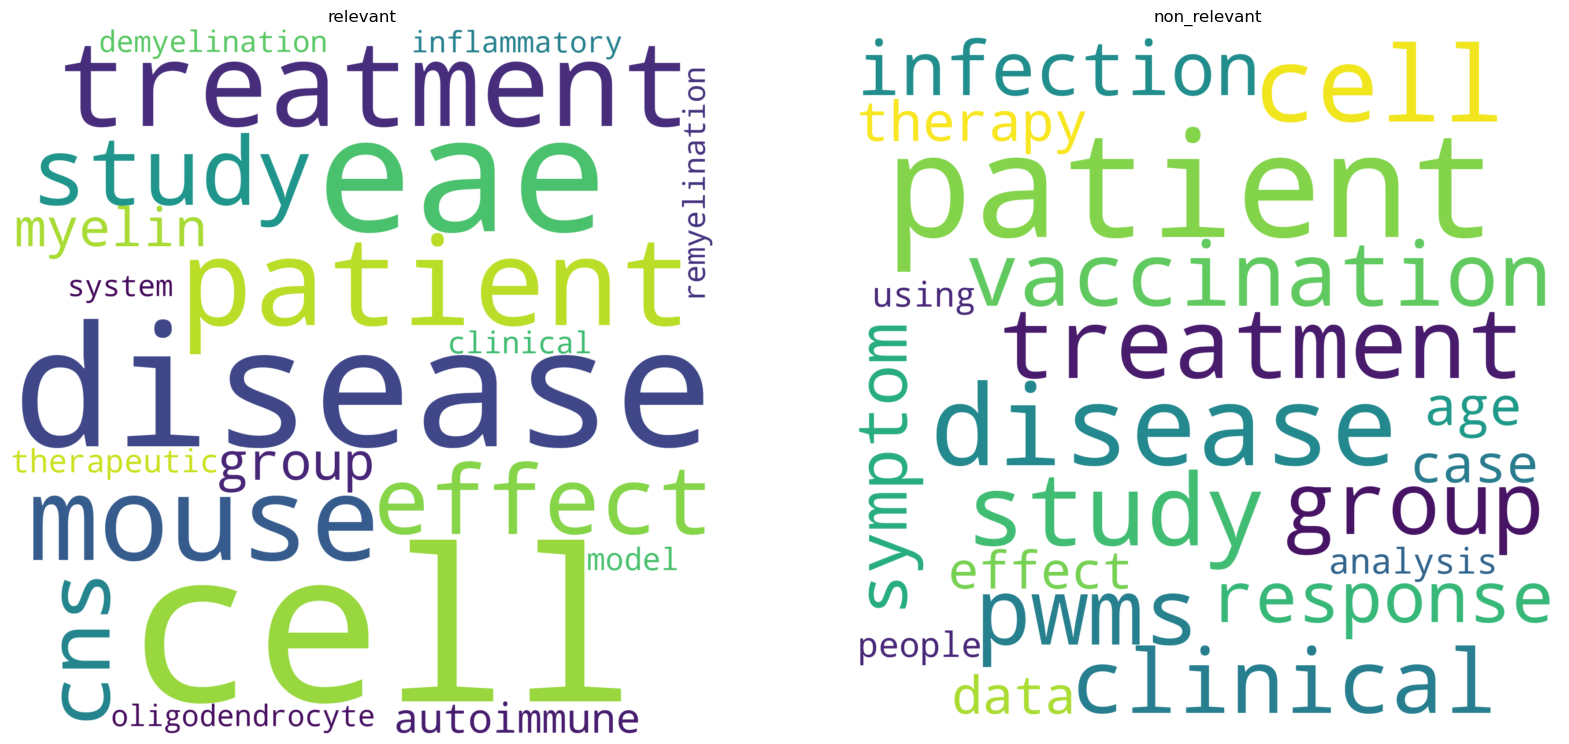

In [337]:
# generate wordclouds for each class using subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, c in enumerate(tfidf_df['class'].unique()):
    df = tfidf_df[tfidf_df['class']==c]
    text = dict(zip(df['feature'], df['score']))
    wordcloud = WordCloud(width=1600, height=1600, background_color='white', max_words=20).generate_from_frequencies(text)
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].axis("off")
    ax[i].set_title(c)
plt.show()


### Differential TF-IDF Analysis
a.k.a Class-Specific Keyword Analysis 

In [338]:

# Function to calculate mean TF-IDF score for each word in a class
def mean_tfidf_scores(matrix, feature_names):
    mean_scores = np.array(matrix.mean(axis=0)).flatten()
    return dict(zip(feature_names, mean_scores))

# Initialize the TF-IDF Vectorizer, excluding stop words
stp_words = ['doi', 'online', 'ahead', 'multiple', 'sclerosis', 'printno']
tfidf_vectorizer = TfidfVectorizer(stop_words=stp_words)

# Separate TF-IDF calculation for each class
tfidf_matrix_relevant = tfidf_vectorizer.fit_transform(processed_relevant)
feature_names_relevant = tfidf_vectorizer.get_feature_names_out()
mean_scores_relevant = mean_tfidf_scores(tfidf_matrix_relevant, feature_names_relevant)

tfidf_matrix_non_relevant = tfidf_vectorizer.fit_transform(processed_non_relevant)
feature_names_non_relevant = tfidf_vectorizer.get_feature_names_out()
mean_scores_non_relevant = mean_tfidf_scores(tfidf_matrix_non_relevant, feature_names_non_relevant)

# Function to find top N differential words
def find_top_differential_words(scores_class1, scores_class2, top_n=10):
    differential_scores = {word: scores_class1.get(word, 0) - scores_class2.get(word, 0) 
                           for word in scores_class1.keys()}
    sorted_differential = sorted(differential_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_differential[:top_n]

# Find top 10 words with high TF-IDF in one class but low in the other
top_differential_words_relevant = find_top_differential_words(mean_scores_relevant, mean_scores_non_relevant)
top_differential_words_non_relevant = find_top_differential_words(mean_scores_non_relevant, mean_scores_relevant)

In [339]:
# turn it into one dataframe
top_differential_words_relevant = pd.DataFrame(top_differential_words_relevant, columns=['feature', 'score'])
top_differential_words_non_relevant = pd.DataFrame(top_differential_words_non_relevant, columns=['feature', 'score'])

# add column with class
top_differential_words_relevant['class'] = 'relevant'
top_differential_words_non_relevant['class'] = 'non_relevant'

# concatenate both dataframes
top_differential_words = pd.concat([top_differential_words_relevant, top_differential_words_non_relevant])

# print top 20 words per class
top_20_differential_words = top_differential_words.groupby('class').head(20).reset_index()

top_20_differential_words.pivot(index='index', columns='class', values=['feature', 'score'])

feature                         score          
class non_relevant         relevant non_relevant  relevant
index                                                     
0          patient              eae     0.021324  0.028392
1      vaccination             cell     0.014608  0.018606
2             pwms            mouse     0.014543   0.01859
3        infection           myelin     0.013091   0.01598
4              age    remyelination     0.009437  0.015739
5             care  oligodendrocyte     0.009325  0.015126
6             case    demyelination     0.008693  0.013781
7          vaccine        microglia     0.008199  0.012687
8       prevalence              cns     0.007798  0.012109
9             pain              msc     0.007242  0.011349

### TF-IDF N-Grams Analysis

In [350]:
# Function to generate n-grams from a list of texts
def generate_ngrams_from_text_list(text_list, n):
    ngrams_list = []
    for text in text_list:
        processed_words = preprocess_lemma(text)
        ngrams_list.extend(list(ngrams(processed_words, n)))
    return ngrams_list

In [351]:
bigrams_relevant = generate_ngrams_from_text_list(processed_relevant, 2)
trigrams_relevant = generate_ngrams_from_text_list(processed_relevant, 3)

# Generate bi-grams and tri-grams for non-relevant class
bigrams_non_relevant = generate_ngrams_from_text_list(processed_non_relevant, 2)
trigrams_non_relevant = generate_ngrams_from_text_list(processed_non_relevant, 3)

#### Basic N-Gram Frequency (Counter)

In [352]:
# Function to get top n-grams from a list of n-grams
def get_top_ngrams(ngrams_list, top_n=10):
    ngrams_counter = Counter(ngrams_list)
    return ngrams_counter.most_common(top_n)

# Get top 10 bi-grams and tri-grams for the relevant class
top_10_bigrams_relevant = get_top_ngrams(bigrams_relevant)
top_10_trigrams_relevant = get_top_ngrams(trigrams_relevant)

# Get top 10 bi-grams and tri-grams for the non-relevant class
top_10_bigrams_non_relevant = get_top_ngrams(bigrams_non_relevant)
top_10_trigrams_non_relevant = get_top_ngrams(trigrams_non_relevant)

# Combine all bi-grams and tri-grams for the whole dataset
all_bigrams = bigrams_relevant + bigrams_non_relevant
all_trigrams = trigrams_relevant + trigrams_non_relevant

# Get top 10 bi-grams and tri-grams for the whole dataset
top_10_bigrams_all = get_top_ngrams(all_bigrams)
top_10_trigrams_all = get_top_ngrams(all_trigrams)

In [353]:
# Displaying the top 10 bi-grams and tri-grams with annotations for each category

print("Top 10 Bi-grams for Relevant Class:")
print(top_10_bigrams_relevant)

print("\nTop 10 Tri-grams for Relevant Class:")
print(top_10_trigrams_relevant)

print("\nTop 10 Bi-grams for Non-Relevant Class:")
print(top_10_bigrams_non_relevant)

print("\nTop 10 Tri-grams for Non-Relevant Class:")
print(top_10_trigrams_non_relevant)

print("\nTop 10 Bi-grams for Whole Dataset:")
print(top_10_bigrams_all)

print("\nTop 10 Tri-grams for Whole Dataset:")
print(top_10_trigrams_all)



Top 10 Bi-grams for Relevant Class:
[(('e', ' '), 18985), (('t', 'i'), 17822), (('i', 'n'), 17586), (('r', 'e'), 14351), (('a', 't'), 14180), (('o', 'n'), 13087), (('d', ' '), 11801), (('e', 'n'), 11309), (('n', ' '), 11193), (('e', 'r'), 11138)]

Top 10 Tri-grams for Relevant Class:
[(('e', 'd', ' '), 9151), (('i', 'o', 'n'), 8030), (('o', 'n', ' '), 7786), (('t', 'i', 'o'), 6634), (('a', 't', 'i'), 6629), (('e', 'n', 't'), 6119), (('a', 'l', ' '), 5789), ((' ', 'r', 'e'), 5159), (('i', 'n', 'g'), 5031), (('n', 'g', ' '), 4826)]

Top 10 Bi-grams for Non-Relevant Class:
[(('e', ' '), 4627), (('t', 'i'), 4034), (('i', 'n'), 3729), (('r', 'e'), 3358), (('a', 't'), 3192), (('o', 'n'), 3159), (('d', ' '), 2906), (('e', 'r'), 2766), (('e', 'n'), 2667), (('t', ' '), 2524)]

Top 10 Tri-grams for Non-Relevant Class:
[(('e', 'd', ' '), 2195), (('i', 'o', 'n'), 1728), (('a', 't', 'i'), 1617), (('o', 'n', ' '), 1576), (('e', 'n', 't'), 1480), (('t', 'i', 'o'), 1387), (('a', 'l', ' '), 1334), (('n

#### TF-IDF analysis of n-grams from the whole dataset.

In [357]:
# Function to calculate top TF-IDF features
def calculate_top_tfidf_features(ngrams_list, top_n=10, n_gram_range=(1,1)):
    # Initialize the TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range)

    # Apply TF-IDF to the n-grams
    tfidf_matrix = tfidf_vectorizer.fit_transform(ngrams_list)

    # Extract feature names and scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    scores = np.array(tfidf_matrix.sum(axis=0)).flatten()
    sorted_scores = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)

    # Select top n features
    return sorted_scores[:top_n]

# Calculate top 10 TF-IDF features for bi-grams and tri-grams
top_10_tfidf_bigrams = calculate_top_tfidf_features(articles.summary, n_gram_range=(2,2))
top_10_tfidf_trigrams = calculate_top_tfidf_features(articles.summary, n_gram_range=(3,3))

# Print the top 10 TF-IDF features for bi-grams and tri-grams
print("Top 10 TF-IDF Features for Bi-grams:", top_10_tfidf_bigrams)
print("Top 10 TF-IDF Features for Tri-grams:", top_10_tfidf_trigrams)

Top 10 TF-IDF Features for Bi-grams: [('multiple sclerosis', 17.376458471476564), ('nervous system', 9.525048982534358), ('central nervous', 9.042238211808627), ('spinal cord', 8.70099695379545), ('experimental autoimmune', 7.555406202527422), ('eae mouse', 7.410499628049084), ('autoimmune encephalomyelitis', 7.248038363955979), ('autoimmune disease', 6.585973479082408), ('encephalomyelitis eae', 6.124878377934972), ('system cns', 5.813428221944752)]
Top 10 TF-IDF Features for Tri-grams: [('central nervous system', 8.730405038124776), ('experimental autoimmune encephalomyelitis', 6.993493422942636), ('autoimmune encephalomyelitis eae', 5.881814081597823), ('nervous system cns', 5.627768719827266), ('disease multiple sclerosis', 3.3853952877445526), ('disease central nervous', 3.3483867607162483), ('patient multiple sclerosis', 2.7427693337018213), ('model multiple sclerosis', 2.535443758588509), ('multiple sclerosis chronic', 2.301528197600976), ('mesenchymal stem cell', 2.282720455090

In [358]:
def compute_tfid_ngrams(documents, ngram_range=(1,1)):
    stp_words = ['doi', 'online', 'ahead', 'printno', 'multiple', 'sclerosis']

    # Initialize the TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words=stp_words, ngram_range=ngram_range)

    # Fit and transform the documents
    X = vectorizer.fit_transform(documents)

    # Get the feature names (words) and their TF-IDF scores
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = X.toarray()

    # Compute the mean TF-IDF score for each word across all documents
    word_scores = tfidf_scores.mean(axis=0)

    # Sort the words by their total score
    word_scores_sorted_indices = word_scores.argsort()[::-1]
    most_frequent_words = [feature_names[i] for i in word_scores_sorted_indices]

    # Create a DataFrame with the most frequent words and their scores
    most_frequent_words = pd.DataFrame(most_frequent_words, columns=['feature'])
    most_frequent_words['score'] = word_scores[word_scores_sorted_indices]

    # Return the DataFrame
    return most_frequent_words


# Compute the most frequent bi-grams and tri-grams
most_frequent_bigrams = compute_tfid_ngrams(articles.summary, ngram_range=(2,2))

most_frequent_trigrams = compute_tfid_ngrams(articles.summary, ngram_range=(3,3))

In [359]:
print(most_frequent_bigrams.head(10))

                        feature     score
0                nervous system  0.008918
1               central nervous  0.008468
2                   spinal cord  0.008129
3       experimental autoimmune  0.007072
4                     eae mouse  0.006928
5  autoimmune encephalomyelitis  0.006784
6            autoimmune disease  0.006164
7         encephalomyelitis eae  0.005732
8                    system cns  0.005442
9                     stem cell  0.005181


In [360]:
print(most_frequent_trigrams.head(10))

                                     feature     score
0                     central nervous system  0.008210
1  experimental autoimmune encephalomyelitis  0.006574
2           autoimmune encephalomyelitis eae  0.005526
3                         nervous system cns  0.005289
4                    disease central nervous  0.003152
5                      mesenchymal stem cell  0.002147
6             oligodendrocyte precursor cell  0.001922
7                         spinal cord injury  0.001871
8                    disability status scale  0.001666
9                encephalomyelitis eae mouse  0.001640


#### TF-IDF analysis of n-grams, within class

In [361]:
# Compute the most frequent bi-grams and tri-grams for relevant class
most_frequent_bigrams_relevant = compute_tfid_ngrams(articles[articles.relevant==True].summary, ngram_range=(2,2))
most_frequent_trigrams_relevant = compute_tfid_ngrams(articles[articles.relevant==True].summary, ngram_range=(3,3))

# Compute the most frequent bi-grams and tri-grams for non-relevant class
most_frequent_bigrams_non_relevant = compute_tfid_ngrams(articles[articles.relevant==False].summary, ngram_range=(2,2))
most_frequent_trigrams_non_relevant = compute_tfid_ngrams(articles[articles.relevant==False].summary, ngram_range=(3,3))

In [362]:
# top 10 bi grams for relevant class and non-relevant class
print(most_frequent_bigrams_relevant.head(10))
print(most_frequent_bigrams_non_relevant.head(10))

# top 10 tri grams for relevant class and non-relevant class
print(most_frequent_trigrams_relevant.head(10))
print(most_frequent_trigrams_non_relevant.head(10))

                        feature     score
0                nervous system  0.010136
1               central nervous  0.009694
2                   spinal cord  0.009549
3       experimental autoimmune  0.008362
4                     eae mouse  0.008348
5  autoimmune encephalomyelitis  0.008042
6            autoimmune disease  0.006883
7         encephalomyelitis eae  0.006825
8                    system cns  0.006403
9                     stem cell  0.006106
                  feature     score
0         healthy control  0.004678
1        retracts article  0.004630
2      autoimmune disease  0.004495
3           among patient  0.004392
4       cladribine tablet  0.004386
5          nervous system  0.004378
6  significant difference  0.004253
7            quality life  0.003832
8         immune response  0.003774
9         patient treated  0.003625
                                     feature     score
0                     central nervous system  0.009398
1  experimental autoimmune encep

#### TF-IDF Analysis of N-Grams Between Classes

In [371]:
def compute_tfidf_ngrams_between_class(documents, ngram_range=(1,1)):
    stp_words = ['doi', 'online', 'ahead', 'printno', 'multiple', 'sclerosis']

    # Initialize the TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words=stp_words, ngram_range=ngram_range)

    # Fit and transform the documents
    X = vectorizer.fit_transform(documents)

    # Get the feature names (words) and their TF-IDF scores
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = X.toarray()

    # Create a DataFrame for each document
    dfs = []
    for i in range(len(documents)):
        # Get the TF-IDF scores for this document
        word_scores = tfidf_scores[i]

        # Sort the words by their score
        word_scores_sorted_indices = word_scores.argsort()[::-1]
        most_frequent_words = [feature_names[j] for j in word_scores_sorted_indices]

        # Create a DataFrame with the most frequent words and their scores
        df = pd.DataFrame(most_frequent_words, columns=['feature'])
        df['score'] = word_scores[word_scores_sorted_indices]

        # Add the DataFrame to the list
        dfs.append(df)

    # Return the list of DataFrames
    return dfs

In [372]:
# create two large strings for relevant and non-relevant class
relevant_string = " ".join(articles[articles.relevant==True].summary)
non_relevant_string = " ".join(articles[articles.relevant==False].summary)

docs = [relevant_string, non_relevant_string]


In [373]:
dfs_bigrams = compute_tfidf_ngrams_between_class(docs, ngram_range=(2,2))
dfs_trigrams = compute_tfidf_ngrams_between_class(docs, ngram_range=(3,3))

In [374]:
dfs_trigrams[0].head(10), dfs_trigrams[1].head(10)

(                                     feature     score
 0                     central nervous system  0.389945
 1  experimental autoimmune encephalomyelitis  0.303998
 2           autoimmune encephalomyelitis eae  0.237150
 3                         nervous system cns  0.202135
 4                    disease central nervous  0.098680
 5                      mesenchymal stem cell  0.096189
 6                encephalomyelitis eae mouse  0.067109
 7                         spinal cord injury  0.062073
 8              model experimental autoimmune  0.060398
 9            oligodendrocyte progenitor cell  0.058161,
                        feature     score
 0       central nervous system  0.049207
 1       deep brain stimulation  0.044734
 2       treatment need patient  0.044010
 3   acute respiratory syndrome  0.035787
 4   expanded disability status  0.035787
 5      disability status scale  0.035787
 6     severe acute respiratory  0.035787
 7          ai confidence score  0.031436
 8   

#### Differentiental TF-IDF for bi-grams and tri-grams WIP

In [375]:
def find_top_differential_words(df1, df2, top_n=10):
    # Merge the two dataframes on 'feature'
    merged = pd.merge(df1, df2, on='feature', how='outer', suffixes=('_class1', '_class2'))

    # Fill NaN values with 0
    merged.fillna(0, inplace=True)

    # Calculate the differential scores
    merged['differential'] = merged['score_class1'] - merged['score_class2']

    # Sort by the differential scores and return the top_n rows
    top_differential = merged.sort_values(by='differential', ascending=False).head(top_n)

    return top_differential

In [376]:
# Calculate differential TF-IDF scores for bi-grams
most_frequent_words_relevant_bigrams = compute_tfid_ngrams(processed_relevant, ngram_range=(2, 2))
most_frequent_words_non_relevant_bigrams = compute_tfid_ngrams(processed_non_relevant, ngram_range=(2, 2))
top_differential_words_relevant_bigrams = find_top_differential_words(most_frequent_words_relevant_bigrams, most_frequent_words_non_relevant_bigrams)
top_differential_words_non_relevant_bigrams = find_top_differential_words(most_frequent_words_non_relevant_bigrams, most_frequent_words_relevant_bigrams)

# Calculate differential TF-IDF scores for tri-grams
most_frequent_words_relevant_trigrams = compute_tfid_ngrams(processed_relevant, ngram_range=(3, 3))
most_frequent_words_non_relevant_trigrams = compute_tfid_ngrams(processed_non_relevant, ngram_range=(3, 3))
top_differential_words_relevant_trigrams = find_top_differential_words(most_frequent_words_relevant_trigrams, most_frequent_words_non_relevant_trigrams)
top_differential_words_non_relevant_trigrams = find_top_differential_words(most_frequent_words_non_relevant_trigrams, most_frequent_words_relevant_trigrams)

In [377]:
most_frequent_words_non_relevant_bigrams.head(10), most_frequent_words_relevant_bigrams.head(10)

(                  feature     score
 0         healthy control  0.004678
 1        retracts article  0.004630
 2      autoimmune disease  0.004495
 3           among patient  0.004392
 4       cladribine tablet  0.004386
 5          nervous system  0.004378
 6  significant difference  0.004253
 7            quality life  0.003832
 8         immune response  0.003774
 9         patient treated  0.003625,
                         feature     score
 0                nervous system  0.010136
 1               central nervous  0.009694
 2                   spinal cord  0.009549
 3       experimental autoimmune  0.008362
 4                     eae mouse  0.008348
 5  autoimmune encephalomyelitis  0.008042
 6            autoimmune disease  0.006883
 7         encephalomyelitis eae  0.006825
 8                    system cns  0.006403
 9                     stem cell  0.006106)

In [378]:
# tri grams
most_frequent_words_non_relevant_trigrams.head(10), most_frequent_words_relevant_trigrams.head(10)

(                            feature     score
 0     measure neurologic evaluation  0.004630
 1            central nervous system  0.003667
 2        acute respiratory syndrome  0.003248
 3          severe acute respiratory  0.003143
 4            deep brain stimulation  0.003048
 5  respiratory syndrome coronavirus  0.003046
 6              journal volume issue  0.002673
 7              faseb journal volume  0.002673
 8                volume issue april  0.002673
 9                 among patient ami  0.002579,
                                      feature     score
 0                     central nervous system  0.009398
 1  experimental autoimmune encephalomyelitis  0.007801
 2           autoimmune encephalomyelitis eae  0.006584
 3                         nervous system cns  0.006230
 4                    disease central nervous  0.003713
 5                      mesenchymal stem cell  0.002633
 6             oligodendrocyte precursor cell  0.002310
 7                         spinal 

In [270]:
non_relevant_articles.count()

216

In [280]:
# check if there is "background" in the non_relevant_articles pd.series
non_relevant_articles.str.contains('ahead').sum()

72

In [289]:
relevant_articles.str.contains('doi').sum()

575

In [286]:
len(relevant_articles)

857

In [284]:
relevant_articles

6        clin optom auckl feb doi ecollection oculomoto...
15       current strategy treatment demyelinating disea...
61       mol immunol feb doi online ahead printabstract...
77       ann clin transl neurol feb doi online ahead pr...
86       mult scler int feb doi ecollection multiple st...
                               ...                        
22474    pharmaceutical basel jul doi conductance calci...
22475    life basel jul doi jelly rj highly nutritious ...
22477    life basel jun doi triggered microbial product...
22478    int j mol sci jul doi precursor several neurod...
22487    mult scler relat disord jul doi online ahead p...
Name: summary, Length: 857, dtype: object

In [271]:
non_relevant_articles

0        j neuroimmunol feb doi online ahead printabstr...
1        brain topogr feb doi online ahead printabstrac...
2        j neurosci nurs feb doi online ahead printabst...
4        j infect dis med microbiol jan doi ecollection...
248      background whilst number publication comparing...
                               ...                        
22385    urologia jul doi online ahead printabstractint...
22456    j autoimmun jul doi online ahead printabstract...
22510    cmaj jul doi oxycodone increasingly prescribed...
22516    j stroke cerebrovasc dis jul doi online ahead ...
22556    abstract background although mainly causing re...
Name: summary, Length: 216, dtype: object

---

In [26]:
# Applying the same logic to calculate differential bi-grams and tri-grams for both classes

# Function to calculate differential n-grams
def find_top_differential_ngrams(tfidf_matrix_class1, feature_names_class1, 
                                  tfidf_matrix_class2, feature_names_class2, top_n=10):
    # Calculate mean TF-IDF scores for each class
    mean_scores_class1 = mean_tfidf_scores(tfidf_matrix_class1, feature_names_class1)
    mean_scores_class2 = mean_tfidf_scores(tfidf_matrix_class2, feature_names_class2)

    # Calculate the differential scores
    differential_scores = {ngram: mean_scores_class1.get(ngram, 0) - mean_scores_class2.get(ngram, 0)
                           for ngram in feature_names_class1}
    sorted_differential = sorted(differential_scores.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_differential[:top_n]

# Calculate differential bi-grams and tri-grams

# TF-IDF Vectorization for bi-grams and tri-grams
tfidf_vectorizer_bigrams = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
tfidf_vectorizer_trigrams = TfidfVectorizer(stop_words='english', ngram_range=(3, 3))

# Apply TF-IDF to bi-grams and tri-grams for each class
tfidf_matrix_relevant_bigrams = tfidf_vectorizer_bigrams.fit_transform([concatenated_relevant])
feature_names_relevant_bigrams = tfidf_vectorizer_bigrams.get_feature_names_out()

tfidf_matrix_non_relevant_bigrams = tfidf_vectorizer_bigrams.fit_transform([concatenated_non_relevant])
feature_names_non_relevant_bigrams = tfidf_vectorizer_bigrams.get_feature_names_out()

tfidf_matrix_relevant_trigrams = tfidf_vectorizer_trigrams.fit_transform([concatenated_relevant])
feature_names_relevant_trigrams = tfidf_vectorizer_trigrams.get_feature_names_out()

tfidf_matrix_non_relevant_trigrams = tfidf_vectorizer_trigrams.fit_transform([concatenated_non_relevant])
feature_names_non_relevant_trigrams = tfidf_vectorizer_trigrams.get_feature_names_out()

# Find top differential bi-grams and tri-grams
top_differential_bigrams_relevant = find_top_differential_ngrams(tfidf_matrix_relevant_bigrams, feature_names_relevant_bigrams, 
                                                                 tfidf_matrix_non_relevant_bigrams, feature_names_non_relevant_bigrams)
top_differential_bigrams_non_relevant = find_top_differential_ngrams(tfidf_matrix_non_relevant_bigrams, feature_names_non_relevant_bigrams, 
                                                                      tfidf_matrix_relevant_bigrams, feature_names_relevant_bigrams)

top_differential_trigrams_relevant = find_top_differential_ngrams(tfidf_matrix_relevant_trigrams, feature_names_relevant_trigrams, 
                                                                   tfidf_matrix_non_relevant_trigrams, feature_names_non_relevant_trigrams)
top_differential_trigrams_non_relevant = find_top_differential_ngrams(tfidf_matrix_non_relevant_trigrams, feature_names_non_relevant_trigrams, 
                                                                       tfidf_matrix_relevant_trigrams, feature_names_relevant_trigrams)


In [27]:
# Creating a DataFrame to display the top differential bi-grams in a tabular format
def create_differential_bigrams_df(bigrams_relevant, bigrams_non_relevant):
    # Convert the top bi-grams lists to DataFrames
    df_relevant = pd.DataFrame(bigrams_relevant, columns=['Bi-gram', 'Score'])
    df_non_relevant = pd.DataFrame(bigrams_non_relevant, columns=['Bi-gram', 'Score'])

    # Add a suffix to distinguish the columns of the two DataFrames
    df_relevant = df_relevant.add_suffix('_Relevant')
    df_non_relevant = df_non_relevant.add_suffix('_Non_Relevant')

    # Combine the DataFrames side by side
    combined_df = pd.concat([df_relevant, df_non_relevant], axis=1)

    return combined_df

# Assuming the lists 'top_differential_bigrams_relevant' and 'top_differential_bigrams_non_relevant' are available
differential_bigrams_df = create_differential_bigrams_df(top_differential_bigrams_relevant, top_differential_bigrams_non_relevant)

# Display the DataFrame
differential_bigrams_df

,Bi-gram_Relevant,Score_Relevant,Bi-gram_Non_Relevant,Score_Non_Relevant
0,optic neuritis,0.461566,ahead printabstractbackground,0.130189
1,binocular vision,0.263752,antibody checked,0.130189
2,near distance,0.263752,case mogigg,0.130189
3,control group,0.197814,case myelitis,0.130189
4,fusional vergence,0.197814,case reactivation,0.130189
5,difference control,0.131876,central nervous,0.130189
6,high percentage,0.131876,checked patient,0.130189
7,negative fusional,0.131876,coinfectionconclusion patient,0.130189
8,neuritis eye,0.131876,complete neurological,0.130189
9,showed significant,0.131876,complication increasingly,0.130189


In [28]:
# Function to create a DataFrame for differential tri-grams
def create_differential_trigrams_df(trigrams_relevant, trigrams_non_relevant):
    # Convert the top tri-grams lists to DataFrames
    df_relevant = pd.DataFrame(trigrams_relevant, columns=['Tri-gram', 'Score'])
    df_non_relevant = pd.DataFrame(trigrams_non_relevant, columns=['Tri-gram', 'Score'])

    # Add a suffix to distinguish the columns of the two DataFrames
    df_relevant = df_relevant.add_suffix('_Relevant')
    df_non_relevant = df_non_relevant.add_suffix('_Non_Relevant')

    # Combine the DataFrames side by side
    combined_df = pd.concat([df_relevant, df_non_relevant], axis=1)

    return combined_df

# Assuming you have the lists 'top_differential_trigrams_relevant' and 'top_differential_trigrams_non_relevant'
differential_trigrams_df = create_differential_trigrams_df(top_differential_trigrams_relevant, top_differential_trigrams_non_relevant)

# Display the DataFrame
differential_trigrams_df

,Tri-gram_Relevant,Score_Relevant,Tri-gram_Non_Relevant,Score_Non_Relevant
0,difference control group,0.163846,ahead printabstractbackground neurological,0.131306
1,negative fusional vergence,0.163846,antibody checked patient,0.131306
2,optic neuritis eye,0.163846,case mogigg myelitis,0.131306
3,showed significant difference,0.163846,case myelitis parainfectious,0.131306
4,significant difference control,0.163846,case reactivation central,0.131306
5,abnormal npc value,0.081923,central nervous setting,0.131306
6,affected parameter likewise,0.081923,checked patient associated,0.131306
7,agematched control enrolled,0.081923,coinfectionconclusion patient neurological,0.131306
8,aim study analyze,0.081923,complete neurological recovery,0.131306
9,alteration binocular vision,0.081923,complication increasingly recognizedcase,0.131306


In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def preprocess_lemma_str(text):
    stop_words = set(stopwords.words('english'))
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    # remove multiple spaces:
    text = re.sub(r'\s+', ' ', text)
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text.lower())
    return ' '.join([lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()])

def calculate_differential_tfidf(df, class_column, text_column, n_gram_range=(2, 3), top_n=10):
    # Check if the specified columns exist in the dataframe
    if class_column not in df.columns or text_column not in df.columns:
        raise ValueError("Specified column does not exist in the dataframe")

    # Check if the n_gram_range and top_n parameters are valid
    if not isinstance(n_gram_range, tuple) or len(n_gram_range) != 2 or n_gram_range[0] > n_gram_range[1]:
        raise ValueError("Invalid n_gram_range. It should be a tuple of two integers where the first is less than or equal to the second")
    if not isinstance(top_n, int) or top_n <= 0:
        raise ValueError("Invalid top_n. It should be a positive integer")

    df[text_column] = df[text_column].apply(preprocess_lemma_str)
    # Separate the relevant and non-relevant texts
    relevant_texts = df[df[class_column] == True][text_column]
    non_relevant_texts = df[df[class_column] == False][text_column]

    # Initialize the TF-IDF Vectorizer for bi-grams and tri-grams
    tfidf_vectorizer_bigrams = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
    tfidf_vectorizer_trigrams = TfidfVectorizer(stop_words='english', ngram_range=(3, 3))

    # Fit the TF-IDF Vectorizer on the relevant and non-relevant texts separately
    tfidf_vectorizer_bigrams.fit(relevant_texts)
    tfidf_vectorizer_trigrams.fit(relevant_texts)

    # Transform the relevant and non-relevant texts separately
    tfidf_matrix_relevant_bigrams = tfidf_vectorizer_bigrams.transform(relevant_texts)
    tfidf_matrix_non_relevant_bigrams = tfidf_vectorizer_bigrams.transform(non_relevant_texts)

    tfidf_matrix_relevant_trigrams = tfidf_vectorizer_trigrams.transform(relevant_texts)
    tfidf_matrix_non_relevant_trigrams = tfidf_vectorizer_trigrams.transform(non_relevant_texts)

    # Extract feature names for bi-grams and tri-grams
    feature_names_bigrams = tfidf_vectorizer_bigrams.get_feature_names_out()
    feature_names_trigrams = tfidf_vectorizer_trigrams.get_feature_names_out()

    # Calculate the mean TF-IDF scores for each class separately
    mean_scores_relevant_bigrams = tfidf_matrix_relevant_bigrams.mean(axis=0).tolist()[0]
    mean_scores_non_relevant_bigrams = tfidf_matrix_non_relevant_bigrams.mean(axis=0).tolist()[0]

    mean_scores_relevant_trigrams = tfidf_matrix_relevant_trigrams.mean(axis=0).tolist()[0]
    mean_scores_non_relevant_trigrams = tfidf_matrix_non_relevant_trigrams.mean(axis=0).tolist()[0]

    # Calculate the differential scores for bi-grams separately for each label
    differential_scores_bigrams = {feature_names_bigrams[i]: mean_scores_relevant_bigrams[i] - mean_scores_non_relevant_bigrams[i]
                                   for i in range(len(feature_names_bigrams))}
    sorted_differential_bigrams = sorted(differential_scores_bigrams.items(), key=lambda x: x[1], reverse=True)

    # Calculate the differential scores for tri-grams separately for each label
    differential_scores_trigrams = {feature_names_trigrams[i]: mean_scores_relevant_trigrams[i] - mean_scores_non_relevant_trigrams[i]
                                    for i in range(len(feature_names_trigrams))}
    sorted_differential_trigrams = sorted(differential_scores_trigrams.items(), key=lambda x: x[1], reverse=True)

    # Select the top n differential features for bi-grams
    top_differential_features_bigrams = sorted_differential_bigrams[:top_n]

    # Select the top n differential features for tri-grams
    top_differential_features_trigrams = sorted_differential_trigrams[:top_n]

    # Create DataFrames for bi-grams and tri-grams
    df_bigrams = pd.DataFrame(top_differential_features_bigrams, columns=['Bi-gram', 'Score'])
    df_trigrams = pd.DataFrame(top_differential_features_trigrams, columns=['Tri-gram', 'Score'])

    return df_bigrams, df_trigrams

In [64]:
# Assuming you have a dataframe named 'articles'
top_differential_bigrams = calculate_differential_tfidf(articles, 'relevant', 'summary', n_gram_range=(2, 2), top_n=10)
top_differential_trigrams = calculate_differential_tfidf(articles, 'relevant', 'summary', n_gram_range=(3, 3), top_n=10)


In [65]:
top_differential_bigrams

(                        Bi-gram     Score
 0       experimental autoimmune  0.009959
 1                     eae mouse  0.009719
 2  autoimmune encephalomyelitis  0.009525
 3               central nervous  0.008345
 4                   spinal cord  0.008119
 5         encephalomyelitis eae  0.007811
 6            multiple sclerosis  0.006074
 7                     stem cell  0.005880
 8                   nervous cns  0.005791
 9                  animal model  0.004456,
                                     Tri-gram     Score
 0  experimental autoimmune encephalomyelitis  0.008883
 1           autoimmune encephalomyelitis eae  0.007204
 2                        central nervous cns  0.005549
 3      ahead printabstractmultiple sclerosis  0.002972
 4         online ahead printabstractmultiple  0.002957
 5                   model multiple sclerosis  0.002805
 6                    disease central nervous  0.002695
 7                      mesenchymal stem cell  0.002590
 8             oligode